## Preliminary Plot

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read in the data file
df = pd.read_table('ka110300.ggs', skiprows=list(range(0, 19)))

# Splitting the big column ['yyyymmdd hhmmss gravity(V) pressure(hPa)'] into new columns
df[['Date', 'Time', 'Gravity(V)', 'Pressure(hPa)']] = df['yyyymmdd hhmmss gravity(V) pressure(hPa)'].str.split(expand=True)

# Drop the old column
df.drop(columns=['yyyymmdd hhmmss gravity(V) pressure(hPa)'], inplace=True)

# Drop any values that are 'None' or blank
df = df.dropna()

# Convert 'Gravity(V)' column to float
df['Gravity(V)'] = df['Gravity(V)'].astype(float)

# Convert 'Date' and 'Time' columns to datetime format, handling exceptions
df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + df['Time'].astype(str), errors='coerce', format='%Y%m%d%H%M%S')
df.dropna(subset=['DateTime'], inplace=True) # Drop rows with NaT (Not a Time)
df.set_index('DateTime', inplace=True)       # Set the index to the DateTime column

# Convert DateTime index to UTC
df_utc = df.tz_localize('UTC')

In [2]:
#df

In [3]:
# Convert gravity readings from volts to micro-gal using Gravity Cal term in dataset
df['Gravity(micro-gal)'] = (df['Gravity(V)'] * -58.04200 )     # Gravity Cal.(ugal/V) = -58.04200

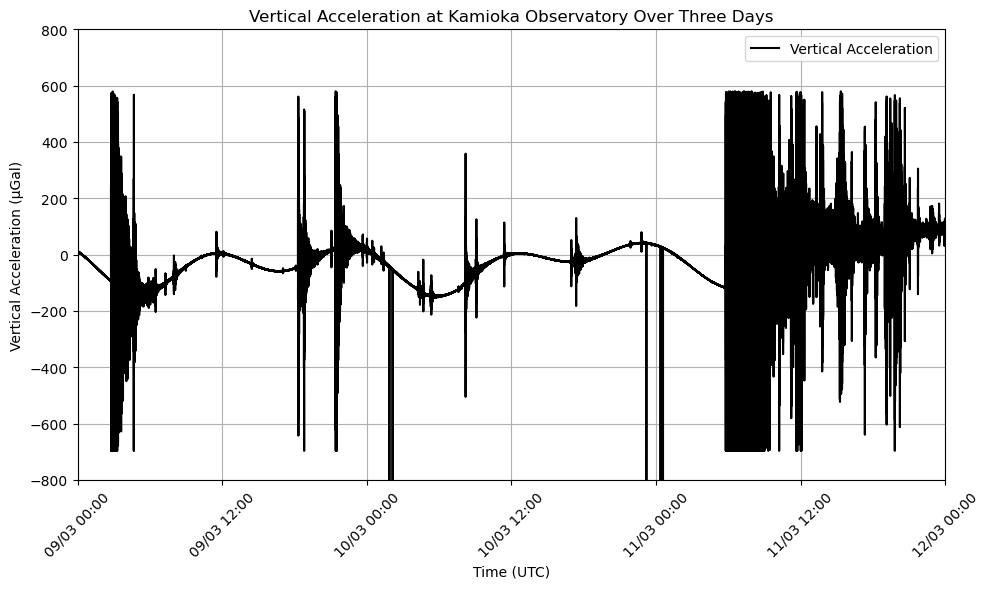

In [4]:
# Calculate the rolling mean of 'Gravity(µGal)' over a specified window size (e.g., 100 data points)
rolling_mean = df['Gravity(micro-gal)'].rolling(window=100).mean()

# Plotting vertical acceleration against date and time
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Gravity(micro-gal)'], color='k', label='Vertical Acceleration')
plt.xlabel('Time (UTC)')
plt.ylabel('Vertical Acceleration (µGal)')
plt.ylim(-800, 800)
plt.title('Vertical Acceleration at Kamioka Observatory Over Three Days')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

# Set x-axis limits from March 9th, 00:00 to March 12th, 00:00
#plt.xlim(pd.Timestamp('2011-03-09 00:00:00'), pd.Timestamp('2011-03-12 00:00:00'))

# Set x-axis limits from March 9th, 00:00 to March 12th, 00:00 in UTC
plt.xlim(pd.Timestamp('2011-03-09 00:00:00', tz='UTC'), pd.Timestamp('2011-03-12 00:00:00', tz='UTC'))

# Format the tick labels to display in this format: 09/03 00:00
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%d/%m %H:%M'))

plt.tight_layout()
plt.show()

This graph suggests the presence of a transient gravity signal whose amplitude does not obviously stand above the background microseism noise.

To achieve an objective signal detection assessment in such a low signal-to-noise environment, avoiding any human bias, we have developed a completely independent statistical detection procedure whose parameters are tuned using only the background data that excludes data recorded in the period around the Tohoku-Oki earthquake (60 days of background data, from 1 March 2011 05:46:00 UTC to 11 March 05:46:00 UTC and from 12 March to 30 April)

## Time Series of Residuals and Reduced Gravity Signal

In [5]:
# Convert 'Pressure(hPa)' to float because we are resampling the whole dataframe in the next line
df['Pressure(hPa)'] = df['Pressure(hPa)'].astype(float)

# Decimate the data to a sampling rate of 0.1 Hz
#df_decimated = df.resample('10S').mean()

In [6]:
#df

In [7]:
#df_decimated

C:\Users\bianc\AppData\Local\Temp\ipykernel_1916\2842878300.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outliers['Pressure(hPa)'] = df_no_outliers['Pressure(hPa)'].astype(float)


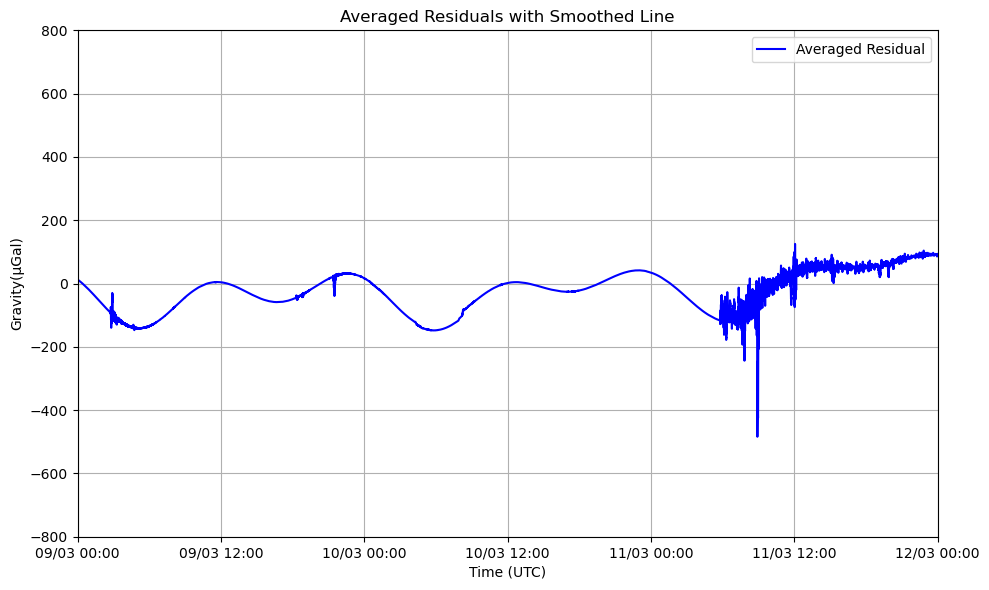

In [20]:
# Convert the 'Date' and 'Time' columns to datetime and set them as the index
#df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%Y%m%d %H%M%S')
#df.set_index('DateTime', inplace=True)

# Calculate Z-score
z_scores = stats.zscore(df['Gravity(micro-gal)'])

# Define threshold for outlier detection (ex: Z-score > 3)
threshold = 3

# Remove outliers
df_no_outliers = df[(z_scores < threshold) & (z_scores > -threshold)]

# Convert 'Pressure(hPa)' to float because we are resampling the whole dataframe in the next line
df_no_outliers['Pressure(hPa)'] = df_no_outliers['Pressure(hPa)'].astype(float)

# Decimate the data to a sampling rate of 0.1 Hz, we need to sample for at least 10s???
df_decimated = df_no_outliers.resample('10S').mean()

# Apply a rolling window of 30 seconds to smooth the residuals
rolling_mean = df_decimated['Gravity(micro-gal)'].rolling(window=30, min_periods=1).mean()
rolling_mean = rolling_mean.dropna()      # Get rid of "Nan" or blank values

# Plot the averaged residuals
plt.figure(figsize=(10, 6))
plt.plot(rolling_mean.index, rolling_mean.values, color='blue', label='Averaged Residual')
plt.xlabel('Time (UTC)')
plt.ylabel('Gravity(µGal)')
plt.ylim(-800, 800)
plt.title('Averaged Residuals with Smoothed Line')
plt.legend()
plt.grid(True)

# Set x-axis limits from March 9th, 00:00 to March 12th, 00:00 in UTC
plt.xlim(pd.Timestamp('2011-03-09 00:00:00', tz='UTC'), pd.Timestamp('2011-03-12 00:00:00', tz='UTC'))

# Format the tick labels to display in this format: 09/03 00:00
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%d/%m %H:%M'))

plt.tight_layout()
plt.show()

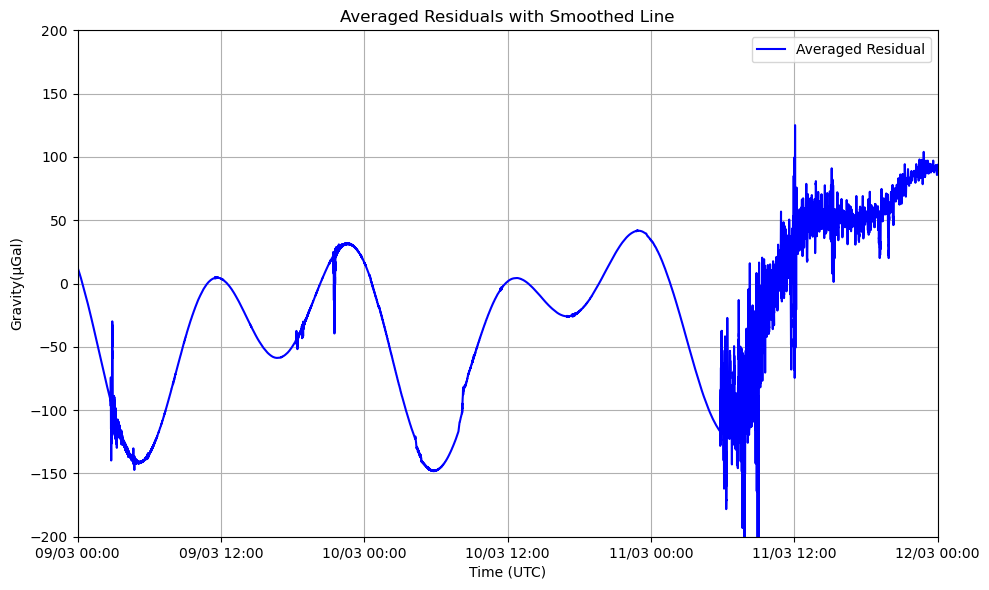

In [21]:
# Plot the Zoomed in averaged residuals
plt.figure(figsize=(10, 6))
plt.plot(rolling_mean.index, rolling_mean.values, color='blue', label='Averaged Residual')
plt.xlabel('Time (UTC)')
plt.ylabel('Gravity(µGal)')
plt.ylim(-200, 200)
plt.title('Averaged Residuals with Smoothed Line')
plt.legend()
plt.grid(True)

# Set x-axis limits from March 9th, 00:00 to March 12th, 00:00 in UTC
plt.xlim(pd.Timestamp('2011-03-09 00:00:00', tz='UTC'), pd.Timestamp('2011-03-12 00:00:00', tz='UTC'))

# Format the tick labels to display in this format: 09/03 00:00
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%d/%m %H:%M'))

plt.tight_layout()
plt.show()

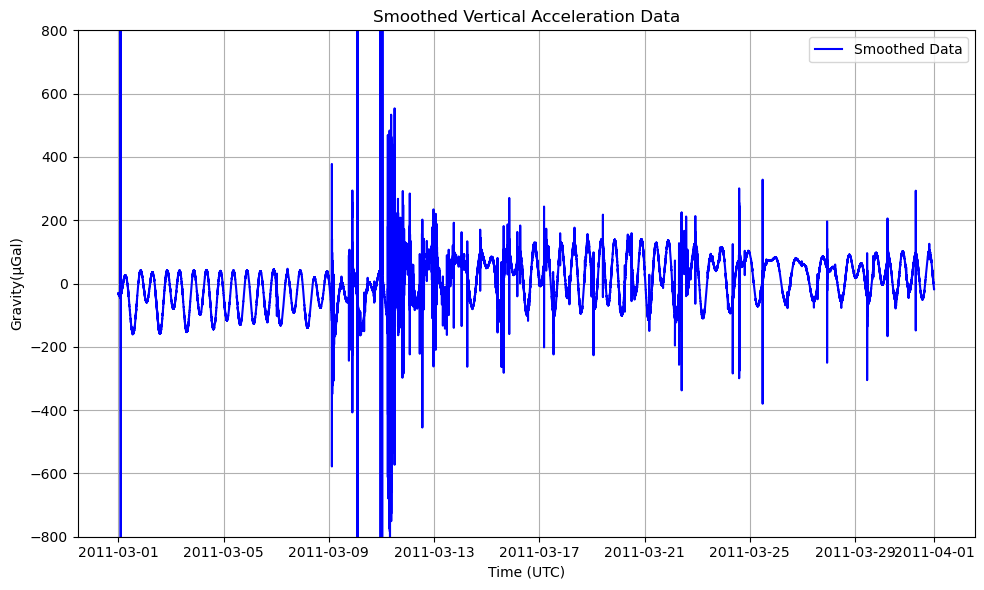

In [15]:
from scipy.signal import savgol_filter

# Apply Savitzky-Golay filter
window_length = 31  # Window length must be odd
polyorder = 3  # Polynomial order
smoothed_data = savgol_filter(df['Gravity(micro-gal)'], window_length, polyorder)

# Plot the smoothed data
plt.figure(figsize=(10, 6))
plt.plot(df.index, smoothed_data, color='blue', label='Smoothed Data')  # Use original DataFrame index
plt.xlabel('Time (UTC)')
plt.ylabel('Gravity(µGal)')
plt.ylim(-800, 800)
plt.title('Smoothed Vertical Acceleration Data')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()